In [47]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pyspark
from pyspark import *
from pyspark.sql import *
from pyspark.sql.functions import *
import re
from pyspark.sql.types import ArrayType
from pyspark.sql.types import StringType

from scripts.libs.milestone2Methods import *
import warnings; warnings.simplefilter('ignore')

# 1) General overview

## 1.0) Used datasets

###  agora

  - ##### Description
  The archive contains scraped html pages from the market's Vendor profiles, Listings, Category Lists, Listing pictures and User profiles. Only the Vendor profiles and the Category List of items were used.



###  agora-forums

  - ##### Description
  The archive contains scraped html pages from the forum's global stats, the topics, the topic list per board. Only the global stats and the topic lists per board were used.


###  grams

  - ##### Description
  The archive contains csv files of requests results obtained on the Grams platform for several services, a search engine for the DarkNet marketplaces. Only the results related to Agora were used.



### [_DNStats_](https://dnstats.net/)
  - #### Description
  The archive contains a single sql files containing the measured ping, http response, and other information made by the DNStats platform over almost 3 years for nearly all DarkNet services. It was promptly pared to retain only the requests made to Agora and Agora-Forum.

## 1.1) Files obtained for each day

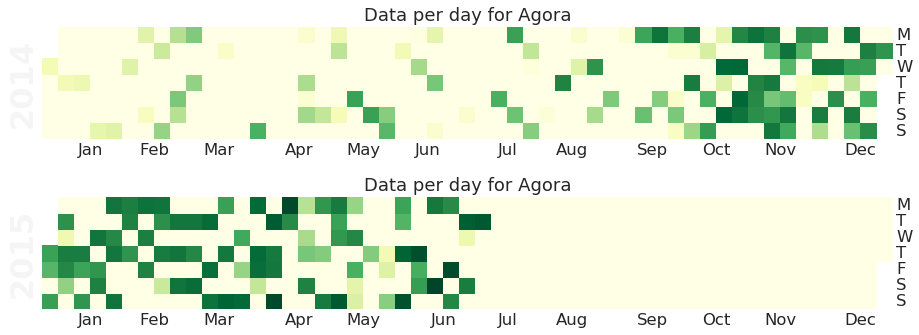

In [113]:
agora_df = pd.read_csv('../data/agora_filesnum.out')
forum_df = pd.read_csv('../data/agora-forum_filesnum.out')
all_days_df = generateFileCount(forum_df, agora_df)
events_ag = pd.Series(all_days_df['filenum_ag'])
events_for = pd.Series(all_days_df['filenum_for'])
calmap.calendarplot(events_ag, daylabels='MTWTFSS', cmap='YlGn', fillcolor='whitesmoke',
                    linewidth=0, fig_kws=dict(figsize=(20, 5)), subplot_kws={'title':'Data per day for Agora'});

>This calendars map show the amount of data per day we have for Agora and Agora Forum. We clearly have a satisfactory amount of data for the market, but we dont have a reliable amount for the forum. There is no stable web scrapping of both websites. In order to understand better this problem, we will study the uptime average of both services in the next part.

## 1.2) Services Uptime

> We then decide to use DNStats which is an up-to-date site tracking darknet markets, products, vendors, news, and more. This way, we can track the amount of available files for each days for Agora depending on the uptime of the sercices, or even see if the Onymous operation had an impact on the services uptime. 


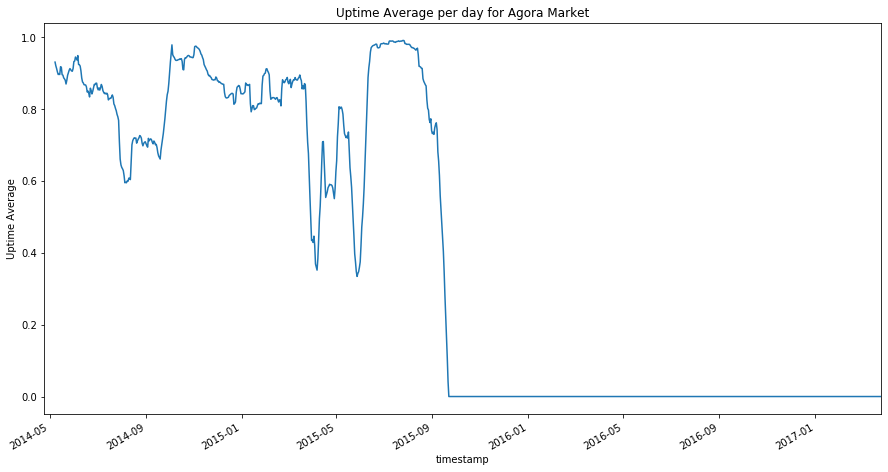

In [26]:
agora_df1 = pd.read_csv('data/agora_stats.out', sep=",")
agora_df1 = agora_df1.drop(columns=['rid', 'speed_download', 'total_time'])
agora_df1['timestamp'] = agora_df1['timestamp'].apply(pd.to_datetime)

agora_df1['siteup'] = agora_df1['httpcode'].apply(fixIsUp)
agora_df1['timestamp'] = agora_df1['timestamp'].apply(truncateTime)

agora_subdf1 = agora_df1[agora_df1['sitename'] == "Agora"]
agora_subdf1 = agora_subdf1.groupby(by='timestamp').mean()
    
plotUptime(agora_subdf1['siteup'], 'Uptime Average per day for Agora Market')

> We observe that the uptime average is very fluctuant over the time for both Agora and Agora Forum. It made the webscrapping quite difficult to do, we have to expect a lot of missing data. Now let's take a look just before and after the Onymous operation

## 1.3) Data Gathering and Parsing
### Gram archives
> The Gram archive is BLABLBLA
### Agora archives
> The Agora archivehas the following tree structure:
```
data/
└── agora
      └── YYYY-MM-DD
          ├── index.html # main page of Agora
          │
          ├── css # css files for the websites
          │
          ├── fonts # fonts for the websites
          │
          ├── info # fixed pages that contains rules and informations
          │
          ├── user # main page of Agora
          │   ├── name_1 # containing the names of users and a send message box
          │   │   [...]
          │   ├── name_N
          │
          ├── cat # Directory containing list of listing for every category
          │   ├── cat_name_hash
          │   │   ├── page_0.html # Contains Title, Ships Fr. Ships To, Price in BTC, vendor_name, rating
          │   ├── [...]
          │   │   ├── page_N.html
          ├── p # Directory containing list of all listings page
          │   ├── listing_0_hash.html
          │   ├── [...]
          │   └── listing_N_hash.html
          └── vendor # Directory containing list of all vendors profile page
              ├── vendor_0_name.html
              ├── [...]
              └── vendor_N_name.html
```
> In order to gather the needed data for our analysis, we decide to parse the following files for each date: 
   - All vendor pages, informations about suppliers, we selected and parsed the following features: 
   - All cat pages, information about available products on the market
   - All user pages, names and number of users for each day
   
   
**Vendors**

|Features Name| Explanaition|
|:---|:---| 
|**name**|Name of the vendor|
|**rating**|Mean rating|
|**lastSeen**|Last time he connects to Agora, with respect to the date of parsing|
|**#products**|number of products available on the market|
|**#Deals**|Approximative number of deals|
|**parsingDate**|Date of the parsing|
|**country**|Country if mentioned|

**Products**

|Features Name| Explaination|
|:---|:---| 
|name|Description of the product|
|from|Origin of the product|
|to|Destination allowed by the vendor|
|vendor|Name of the vendor|
|cat|Category of the product|
|cat_hash|unique hash of the category|
|date|Date of the parsing|

**User**

|Features Name| Explaination|
|:---|---| 
|name| Name of the user|
|parsingDate| Date of the parsing|


## 1.4) Data Cleaning & Enrichment

In [39]:
vendorsDF = pd.read_csv('saved_gen_df/vendorsDF_lastSeen_country_df.csv').drop(columns=['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'])

FileNotFoundError: [Errno 2] File b'saved_gen_df/vendorsDF_lastSeen_country_df.csv' does not exist: b'saved_gen_df/vendorsDF_lastSeen_country_df.csv'

In [142]:
vendorsDF.head(10)

name  rating    lastSeen  #products    #Deals parsingDate  \
0      littlegoblin   4.920  2014-09-19       14.0   150~200  2014-09-20   
1    Rebel_Alliance   4.990  2014-09-19        7.0   300~500  2014-09-20   
2     ThePartyDepot   5.000  2014-09-19        3.0    70~100  2014-09-20   
3          cossacks   4.990  2014-09-19        7.0   300~500  2014-09-20   
4        checkpoint   4.840  2014-09-19       31.0     55~70  2014-09-20   
5    GermanTerminal   4.994  2014-09-19       37.0  500~1000  2014-09-20   
6               AGP   4.910  2014-09-18        2.0    70~100  2014-09-20   
7       Top_Gear_UK   4.830  2014-09-19       21.0  500~1000  2014-09-20   
8  onefamilyonelove     NaN  2014-09-19        4.0         0  2014-09-20   
9            xinhai   4.974  2014-09-20       10.0     1000+  2014-09-20   

     country  
0         EU  
1     Canada  
2  Australia  
3         UK  
4    Belgium  
5    Germany  
6  Australia  
7         UK  
8        USA  
9        USA

We remove the date were the number of vendors is inferior to 150 since they are obviously consequence of a technical problem


In [143]:
nbVendorbyDate = vendorsDF[['parsingDate', 'name']].groupby(['parsingDate']).agg([ 'count'])
nbVendorbyDate = nbVendorbyDate[nbVendorbyDate[('name', 'count')] >150]

Clearly, we see that this measure is not exploitable like this, vendor data will need to be enriched to obtain a significant representation of their population.

### Number of listing per Vendor

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f24963f4ef0>]],
      dtype=object)

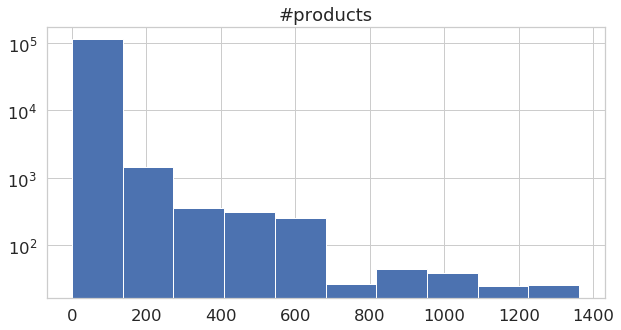

In [145]:
vendorsDF.hist(column='#products',log=True,figsize=(10,5))

This plot shows the huge variation inn the number of products sold by vendors. That means studying this feature might be insightful in order to understand the state of the market and the vendor population.

## Market Analysis

>In this section, we will try to understand all the products listed in agora-market that we managed to retrieve.
Let's first get our dataframe containing all the parsed products from the scrapping made between 2014/01/01 to 2015/08/01.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
from scripts.libs.milestone2Methods import *
import scripts.nbProductsParse as t

In [5]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
df = spark.read.option("header", "true").csv("data/cat_csv/*.csv")
df.count()

2805212

>So in total we have parsed 2805212 products, we selected the following features: 

In [6]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- name: string (nullable = true)
 |-- price: string (nullable = true)
 |-- from: string (nullable = true)
 |-- to: string (nullable = true)
 |-- vendor: string (nullable = true)
 |-- cat_hash: string (nullable = true)
 |-- cat: string (nullable = true)
 |-- date: string (nullable = true)



### Cleaning
> After some analysis, we cleaned the data as follow, the cleaning methods are available in the file scripts/libs/milestone2Methods: 

In [7]:
df = cleanListings(df)

### Number of products availables on the market
> Once our data cleaned, we wanted to know if the number of listing per day parsed was consistent, it is possible that sometimes, since we have seen that the market was highly instable, the scrapping for a certain day was incomplete before the site went down, in this case we will not be able to use these datas 


#### Raw data

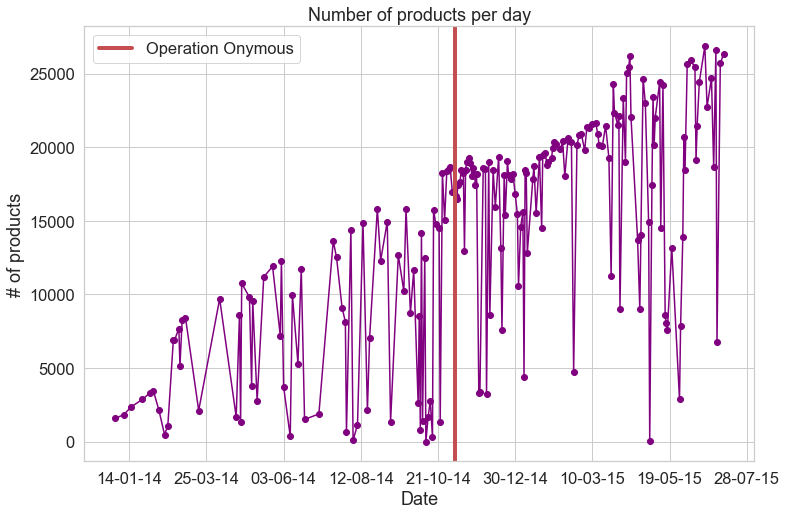

In [9]:
products_per_day = df.groupby("date").agg(count("date").alias("numberOfProductsParsed")).toPandas()
products_per_day = products_per_day[products_per_day['date'].str.contains("\d\d\d\d-\d\d-\d\d")]
products_per_day['date'] = pd.to_datetime(products_per_day['date'],infer_datetime_format=True) 
products_per_day = products_per_day.sort_values(by='date', ascending=True, na_position='first')

plotNDate(products_per_day['date'],products_per_day['numberOfProductsParsed'], 10,"Number of products per day", "# of products")


> We can see here that we have a lot of missing values, the number of products increase linearly but it drop a lot unpredictably, it seems to be due to the market instability, as explained previously.

#### Estimation

>In order to get the correct number of products per date, we parsed the main page of Agora, in which there is an approximation by category of the number of product, for example, if the category Drugs contains 1086 products one day, the website will inform 1000+ produtcs in that category. By adding the numbers given for each category we can approximate the number of products for each day and estimate if the products we effectively parsed are correct or not.

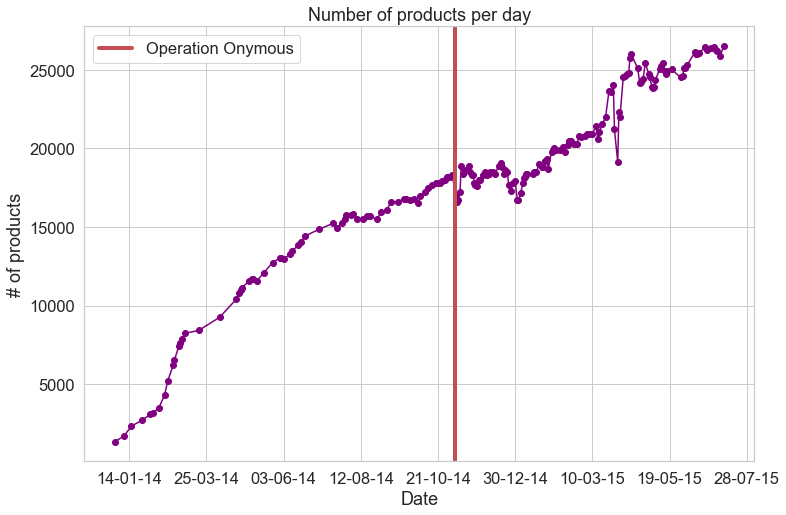

In [10]:
products_per_day_estimated = t.directoryToDF("data/index/")
products_per_day_estimated['date'] = pd.to_datetime(products_per_day_estimated['date'],infer_datetime_format=True) 
products_per_day_estimated = products_per_day_estimated.sort_values(by='date', ascending=True, na_position='first')
plotNDate(products_per_day_estimated['date'],products_per_day_estimated['numberOfProducts'], 10,"Number of products per day", "# of products")

> We can see here that if we pick the number of products obtained in the main page of agora, the result seems more predictable than before, it could be a solution to our missing data problem, we just need to compare this values to the ones previously obtained with our list of all products per year and keep only the date in which we have a satisfactory amount of data compare to the numbers shown on the agora main page. 
> Furthemore, we observe a decrease in the number of products just during the onymous operation

#### Filtering of badly scrapped days

> Now that we have our estimation of the actual numbers of products available on Agora Market, we can delete the days in which we have highly missing datas. In order to keep a fair amount of data points, we fixed the ratio between the estimate number of products and the parsed one to 90%.

In [11]:
# Join Estimated and Parsed products and add ratio
good_dates = pd.merge(left=products_per_day,right=products_per_day_estimated, left_on='date', right_on='date')
good_dates['ratio_parsed_estimated'] = (100*good_dates['numberOfProductsParsed']/good_dates['numberOfProducts'])

# Remove the dates that have a number of products too different
good_dates = good_dates[good_dates['ratio_parsed_estimated'] > 90]
good_dates['date'] = pd.to_datetime(good_dates['date'],infer_datetime_format=True) 

# Remove the dates that are too close to each other < 3 days
good_dates["diff"] = good_dates.date.diff().dt.days.fillna(0)
good_dates['diff'] = good_dates['diff'].rolling(window=2).sum()
good_dates = good_dates[good_dates['diff'] > 3]

good_dates.count()

date                      84
numberOfProductsParsed    84
numberOfProducts          84
ratio_parsed_estimated    84
diff                      84
dtype: int64

> After the filtering we keep 84 dates out of 201, luckily, most of the wrongly scrapped days are not during Onymous but eralier in 2014, if we plot again the actual number of products per days parsed with the filtered dates we get the following graph: 

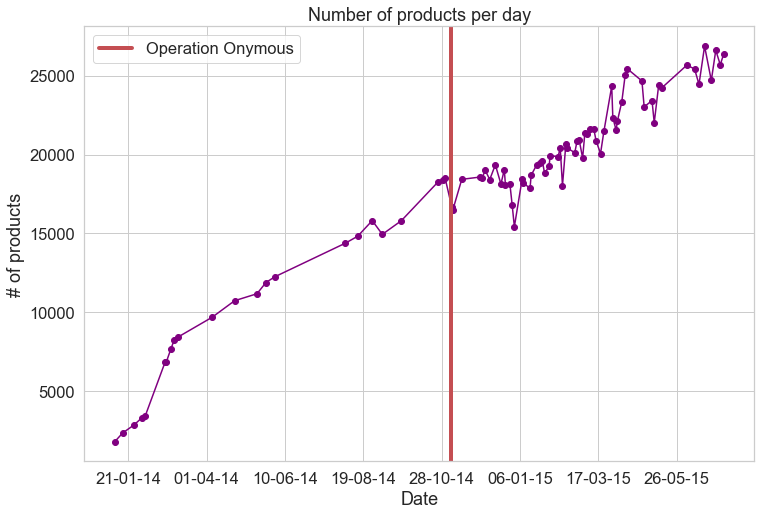

In [12]:
plotNDate(good_dates['date'],good_dates['numberOfProductsParsed'], 10,"Number of products per day", "# of products")

> Althought more than 3/4 of the data we parsed is highly incomplete, the graph above tells us that during the period of Onymous, the data is often complete, this quite helpful for us. We can observe here a gap in the number of products available on Agora just after Onymous, indeed, the operation had an impact on the market but it recovers quickly. Now that we can trust our data, let's filter our df containing all the products with this dates.

In [13]:
dates = good_dates['date'].apply(lambda x: x.strftime('%Y-%m-%d')).values
df = df.filter(col('date').isin(dates.tolist()))

### Active vendors

> Here we want to see if the total number of active vendors by day, was impacted by Onymous

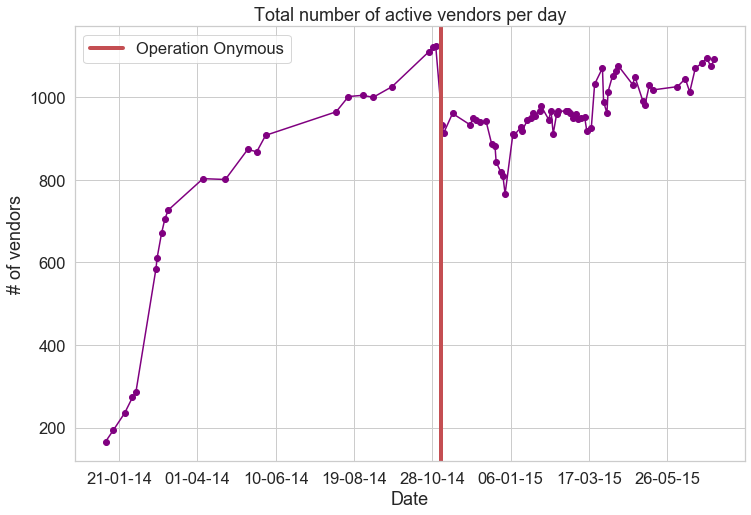

In [14]:
# Get the number of distinct vendors by date
vendors = df.groupby("date").agg(countDistinct('vendor').alias("numberOfVendor")).toPandas()
vendors['date'] = pd.to_datetime(vendors['date'],infer_datetime_format=True) 
vendors = vendors.sort_values(by='date', ascending=True, na_position='first')
vendors.set_index('date', inplace=True)

# Plot
plotNDate(vendors.index,vendors['numberOfVendor'], 10,"Total number of active vendors per day", "# of vendors")


>We can see here that 311 vendors was either removed or removed their products just during the operation Onymous and it seems to never recover before the site was definitevely shutdown in august 2015. Let's see if those missing vendors quit definitevely and if the upside trend is due to new vendors on the platform : 

In [51]:
# TODO

### Big vs Small suppliers

> In order to better understand why some of the vendors left when others stayed, we decide to analyse the number of products selled by each supplier

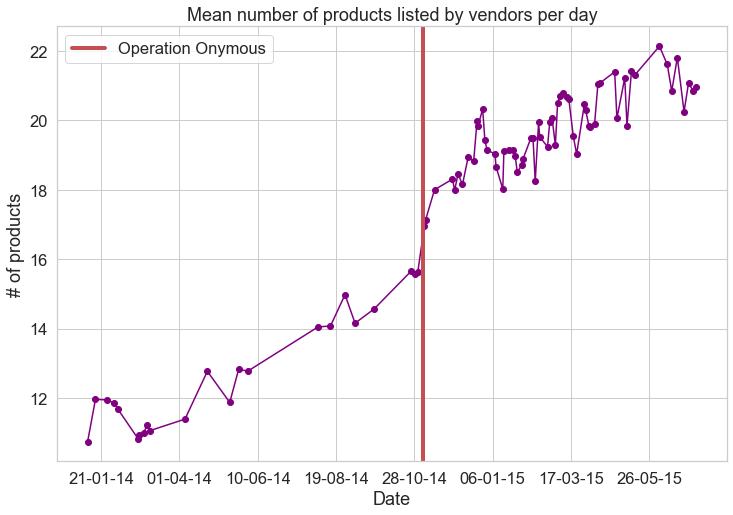

In [15]:
nbposts_per_vendors_date = df.groupby("date", "vendor").agg(countDistinct('name').alias("numberOfPosts")).toPandas()
nbposts_per_vendors_date['date'] = pd.to_datetime(nbposts_per_vendors_date['date'],infer_datetime_format=True) 
nbposts_per_vendors_date = nbposts_per_vendors_date.sort_values(by='date', ascending=True, na_position='first')
nbposts_per_vendors_date = nbposts_per_vendors_date.set_index('date')
nbposts_per_vendors_date.head()
plotNDate(nbposts_per_vendors_date.groupby("date").median().index,nbposts_per_vendors_date['numberOfPosts'].groupby("date").mean(), 10,"Mean number of products listed by vendors per day", "# of products")

>We can see here that the mean number of products listed by the active suppliers is increasing a lot just after Onymous, since the number of suppliers is decreasing at this period, it may means that those who left had lower mean number of products to sell than those who stayed, let's demonstrate this by plotting the mean number of products for each categories:

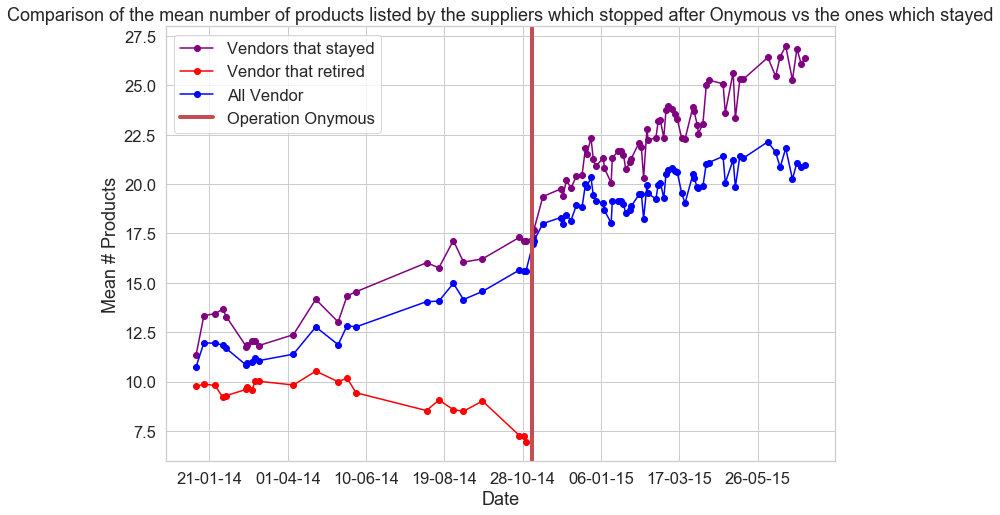

In [17]:
before = df.filter(df.date < "2014-11-05").select('vendor').distinct().toPandas()
after = df.filter(df.date > "2014-11-05").select('vendor').distinct().toPandas()

vendors_that_stayed = before[before['vendor'].isin(after['vendor'])]
vendors_that_retired = before[~before['vendor'].isin(after['vendor'])]
vendors_that_stayed = nbposts_per_vendors_date[nbposts_per_vendors_date['vendor'].isin(vendors_that_stayed.values.squeeze())].groupby('date').mean()
vendors_that_retired = nbposts_per_vendors_date[nbposts_per_vendors_date['vendor'].isin(vendors_that_retired.values.squeeze())].groupby('date').mean()
all_vendors = nbposts_per_vendors_date.groupby('date').mean()
plot3Date(vendors_that_stayed, vendors_that_retired,all_vendors )

> The above chart confirm our hypothesis, indeed the mean number of products available each day by the vendors is higher for those who stayed after Onymous than those who stopped. Moreover, the "big" sellers seems to grow faster than the all the active vendors after Onymous.

### New vendors
> While the Onymous operation has had a significant negative impact on the total number of suppliers in the Agora market, it has also closed other large markets, such as Silkroad, so we can ask ourselves if the closing of these markets entails moving users to Agora. 

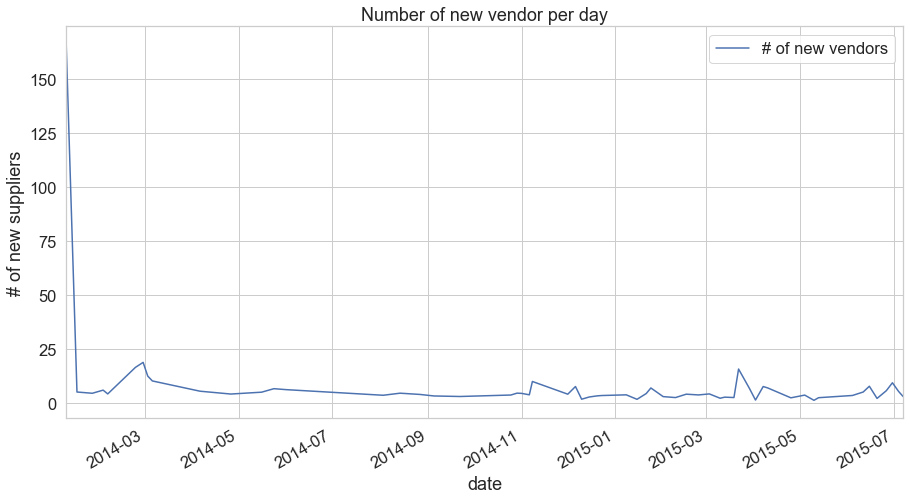

In [313]:
new_vendors = pd.DataFrame()
new_vendors['count'] = posts_per_vendors_date[~posts_per_vendors_date.duplicated(subset="vendor", keep='first')]['vendor'].groupby('date').count()

new_vendors.reset_index(level=0, inplace=True)
new_vendors['difference'] = new_vendors['date'].diff().fillna(0)
new_vendors['# of new vendors'] = new_vendors['count']/(new_vendors['difference'].dt.days + 1)
new_vendors = new_vendors[['date', '# of new vendors']]
new_vendors.set_index('date', inplace=True)

fig, ax1 = plt.subplots( figsize=(15,8))
ax1.set_ylabel('# of new suppliers')
new_vendors.rolling(window=1).mean().plot(
      kind='line', use_index=True, ax=ax1)
ax1.tick_params(axis='y')
plt.title("Number of new vendor per day")
plt.show()



>We can see here that this is not the case, the number of new suppliers who publish a product each day is relatively stable, about 5 per day. A vendor is considered new the day when he publish is first product.

### Displaced Vendors

> We saw that the Onymous operation had a significant impact on the suppliers of Agora Market, a lot of small vendors retired after this operation. In another hand, the operation didn't seem to impact the big suppliers of Agora. We assume that these conclusion are true for other market such as Silkroad, the small suppliers left after it was close and the big suppliers continue their deals on other platforms. But if this is the case, how can we explain that we don't see any upward trend in the number of new suppliers after the operation on Agora ? We made the assumption that it was because most of the big suppliers had already an account on several market. We compared the username of the suppliers present on Agora and Silkroad, BLAVLA and VLAVLA before Onymous.
In order to compare usernames, since some times sellers use slightly different name (Uppercase letters, number instead of letters, etc..) we also compared them with an hamming distance equal or inferior to 1 and lowercased all usernames

In [42]:
vendors = nbposts_per_vendors_date.reset_index().groupby('vendor').agg({'date': [np.min,np.max]}).rename(columns={"amin": "date_min", "amax": "date_max"})
vendors.columns = vendors.columns.droplevel()


> We can see here that BLABLABLA

## Product Analysis

### Type of products

> First of all, we wanted to know if the type of products was impacted by the operation onymous, you can find below a stacked chart of the number of products in each categories available on Agora

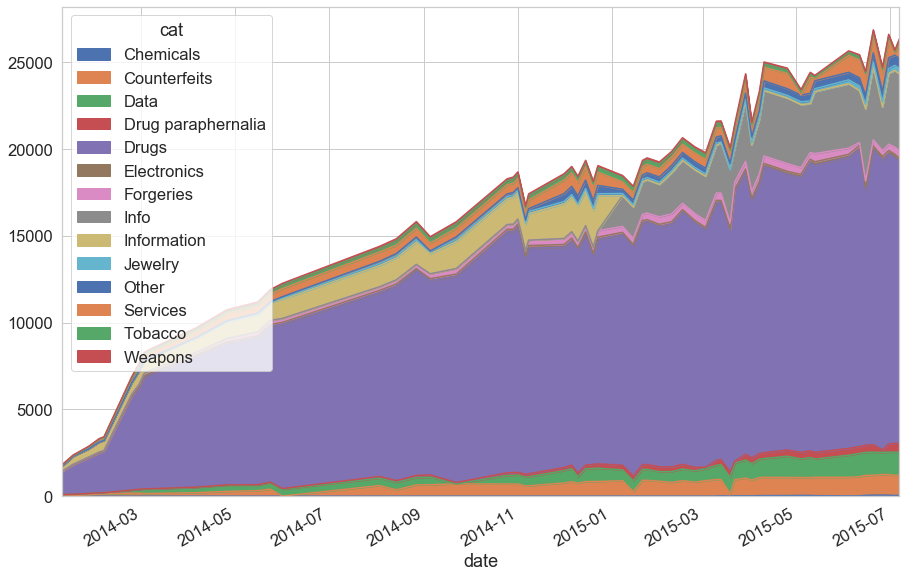

In [316]:
def processCat(cat):
    # Take only top category
    cleanr = cat.split("/")
    return cleanr[0]

udf_func_C = udf(processCat, StringType())

categories=df.withColumn("cat", udf_func_C(col("cat")))
categories = categories.select("date", "cat").groupby('date', 'cat').count().toPandas()
categories['date'] = pd.to_datetime(categories['date'],infer_datetime_format=True) 
categories_count = categories.sort_values(by='date', ascending=True, na_position='first')
categories_count = pd.pivot_table(categories_count, values='count', index='date',
                     columns=['cat'])
categories_count = categories_count.fillna(0)
categories_count.loc[merged_inner['date']].plot.area(figsize=(15,10))

> We can see here that there is no significatif impact on the proportion of each categories

### Price 

> BLABLABLA

In [19]:
# TODO

> BLABLABLA

### Price by Category
> BLABLABLA

In [ ]:
# TODO

> BLABLABLA

## Import/Export Analysis

In the further analysis we will focus on the importation/exportation toward several continents: 

In [321]:
date = merged_inner['date'].apply(lambda x: x.strftime('%Y-%m-%d')).values
date = date[:22]
date

array(['2014-01-09', '2014-01-16', '2014-01-26', '2014-02-02',
       '2014-02-05', '2014-02-23', '2014-02-28', '2014-03-03',
       '2014-03-06', '2014-04-06', '2014-04-26', '2014-05-16',
       '2014-05-24', '2014-06-01', '2014-08-03', '2014-08-14',
       '2014-08-27', '2014-09-05', '2014-09-22', '2014-10-25',
       '2014-10-29', '2014-11-01'], dtype=object)

In [50]:


udf_func_C = udf(countryToContinent, StringType())
confusion_matrix = df.select('date', pyspark.sql.functions.explode(col("to")).alias("to"), "from")
confusion_matrix = confusion_matrix.select('date', pyspark.sql.functions.explode(col("from")).alias("from"), "to")
confusion_matrix = confusion_matrix.withColumn("from", udf_func_C(col("from")))
confusion_matrix = confusion_matrix.withColumn("to", udf_func_C(col("to")))
confusion_matrix = confusion_matrix.groupby("from", "to").count()
confusion_matrix = confusion_matrix.filter(~col('from').isin("None")).filter(~col('to').isin("None"))
confusion_matrix = confusion_matrix.toPandas()

# Pivote the table
confusion_matrix = pd.pivot_table(confusion_matrix, values='count', index='from',
                     columns=['to'], dropna=False, fill_value=0)


confusion_matrix = confusion_matrix[['america', 'asia', 'europe', 'oceania', 'others', 'worldwide']]
confusion_matrix['america'] += confusion_matrix['worldwide']
confusion_matrix['asia'] += confusion_matrix['worldwide']
confusion_matrix['europe'] += confusion_matrix['worldwide']
confusion_matrix['oceania'] += confusion_matrix['worldwide']
confusion_matrix['others'] += confusion_matrix['worldwide']

confusion_matrix = confusion_matrix.drop('worldwide', axis=1)
confusion_matrix = confusion_matrix.drop('worldwide')

# Get ratio 
#confusion_matrix = confusion_matrix.div(confusion_matrix.sum(axis=1), axis=0)



In [323]:
confusion_matrix.values

array([[16103,     0,    12,    13,   370, 10425],
       [   39,     0,    25,     0,   148,  6039],
       [   17,     3, 10537,     2,  3516, 18981],
       [    0,     0,     0,  4563,   513,   495],
       [   77,     0,     0,   239,   409,  5782],
       [    3,     0,    41,     0,    14,  6034]])

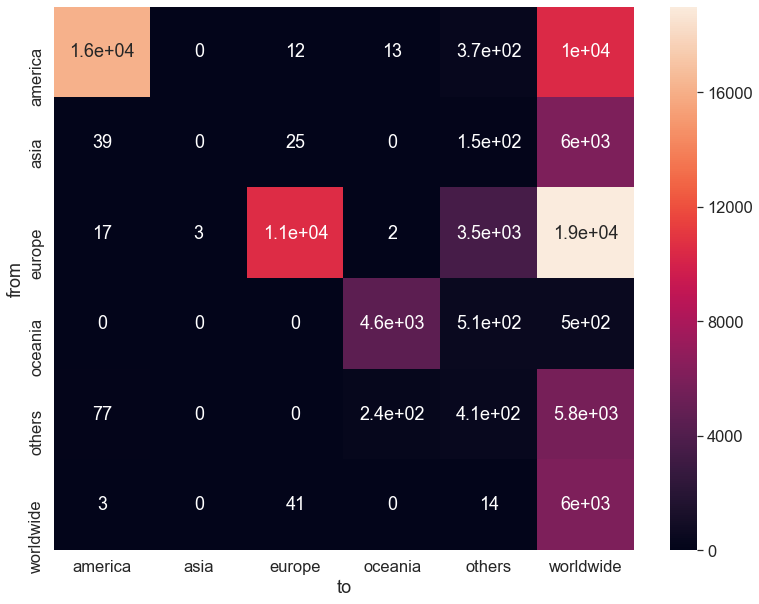

In [324]:
fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(confusion_matrix, annot = True, ax=ax)

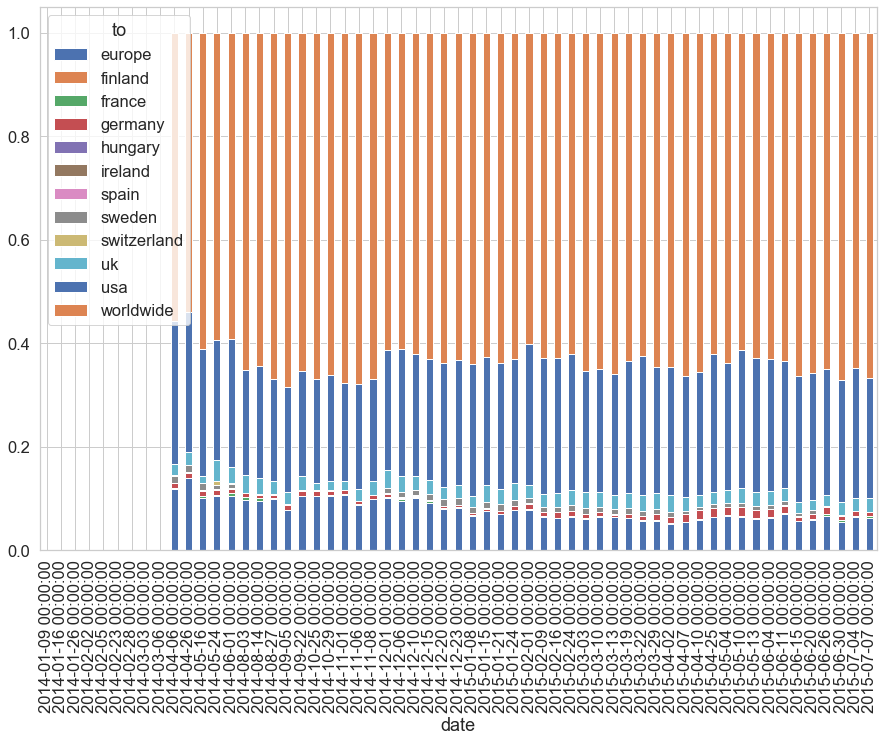

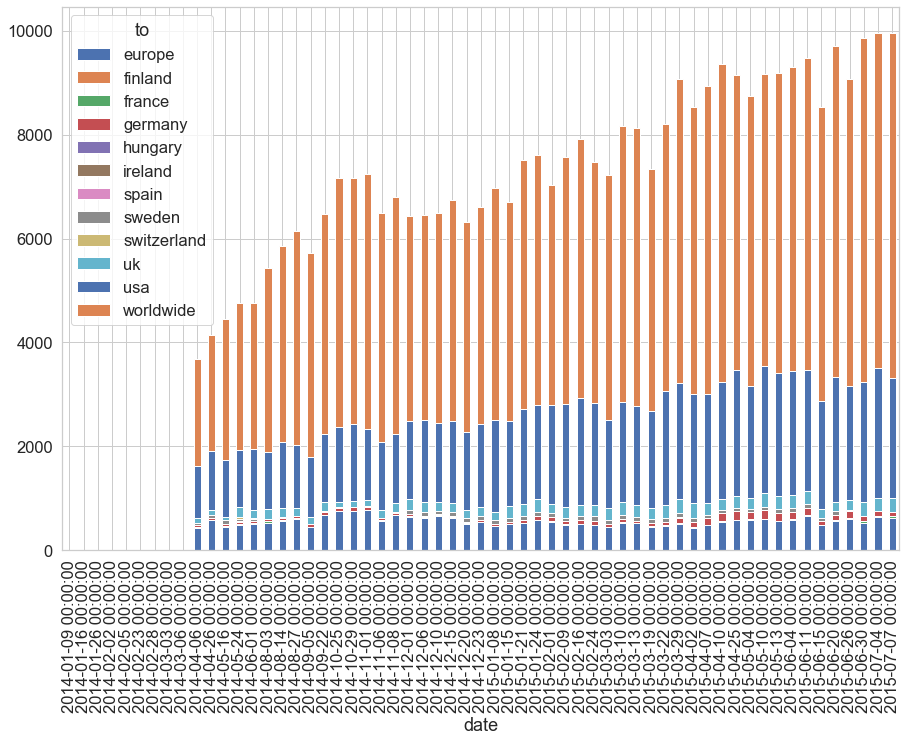

In [317]:
pd.set_option('display.max_rows', 200)
countries = ['worldwide','bulgaria', 'usa', 'france', 'germany', 'europe', 'finland', 'uk', 'sweden', 'hungary', 'ireland', 'latvia', 'lituania', 'luxembourg', 'netherland', 'romania', 'spain', 'switzerland']
filtered_tos=df.withColumn("cat", udf_func_C(col("cat"))).filter(col('cat').isin("Drugs"))
filtered_tos = df.select('date', pyspark.sql.functions.explode(col("to")).alias("to")).groupby('date', 'to').count().filter(col('to').isin(countries)).toPandas()
filtered_tos['date'] = pd.to_datetime(filtered_tos['date'],infer_datetime_format=True) 
filtered_tos = filtered_tos.sort_values(by='date', ascending=True, na_position='first')
filtered_tos = pd.pivot_table(filtered_tos, values='count', index='date',
                     columns=['to'])

#Filter only consistent data
filtered_tos = filtered_tos.loc[merged_inner['date']]

# Get ratio and plot
filtered_tos.div(filtered_tos.sum(axis=1), axis=0).plot.bar(stacked=True, figsize=(15,10))
filtered_tos.plot.bar(stacked=True, figsize=(15,10))

In [9]:
all_countries = df.groupby("from").agg(count("from"))
all_countries.count()

274

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
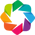

:Chord   [america,asia]   (europe,oceania,others,worldwide)

In [325]:
import pandas as pd
import holoviews as hv
from holoviews import opts, dim
from bokeh.sampledata.les_mis import data

hv.extension('bokeh')
hv.output(size=200)


hv.Chord(confusion_matrix)


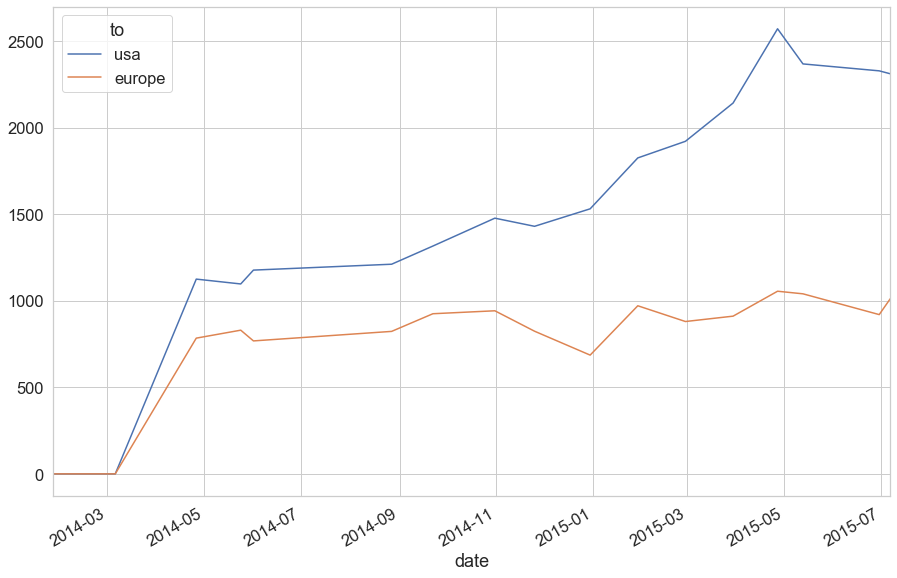

In [244]:
filtered_tos = filtered_tos.fillna(0)
test = filtered_tos[['usa', 'europe']]
test['europe'] += filtered_tos['uk']
test['europe'] += filtered_tos['germany']
test['europe'] += filtered_tos['france']
test['europe'] += filtered_tos['finland']
test['europe'] += filtered_tos['sweden']
test['europe'] += filtered_tos['hungary']
test['europe'] += filtered_tos['ireland']
test['europe'] += filtered_tos['spain']
test['europe'] += filtered_tos['switzerland']
#filtered_tos[['usa', 'uk', 'europe', 'germany', 'france', 'finland', 'sweden','hungary', 'ireland', 'spain', 'switzerland']].plot(figsize=(15,10))
test.plot(figsize=(15,10))
#test['europe']

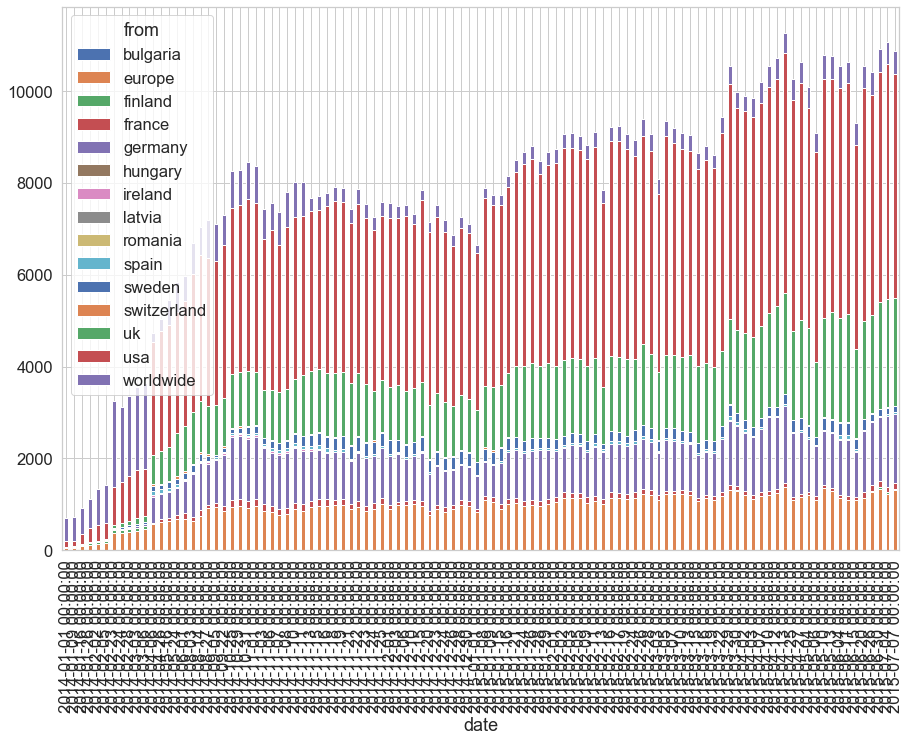

In [129]:
pd.set_option('display.max_rows', 200)
countries = ['worldwide','bulgaria', 'usa', 'france', 'germany', 'europe', 'finland', 'uk', 'sweden', 'hungary', 'ireland', 'latvia', 'lituania', 'luxembourg', 'netherland', 'romania', 'spain', 'switzerland']
filtered_tos=df.withColumn("cat", udf_func_C(col("cat"))).filter(col('cat').isin("Drugs"))
filtered_tos = df.select('date', pyspark.sql.functions.explode(col("from")).alias("from")).groupby('date', 'from').count().filter(col('from').isin(countries)).toPandas()
filtered_tos['date'] = pd.to_datetime(filtered_tos['date'],infer_datetime_format=True) 
filtered_tos = filtered_tos.sort_values(by='date', ascending=True, na_position='first')
filtered_tos = pd.pivot_table(filtered_tos, values='count', index='date',
                     columns=['from'])

#Filter only consistent data
filtered_tos = filtered_tos.loc[merged_inner['date']]

# Get ratio and plot
#filtered_tos.div(filtered_tos.sum(axis=1), axis=0).plot.bar(stacked=True, figsize=(15,10))
filtered_tos.plot.bar(stacked=True, figsize=(15,10))

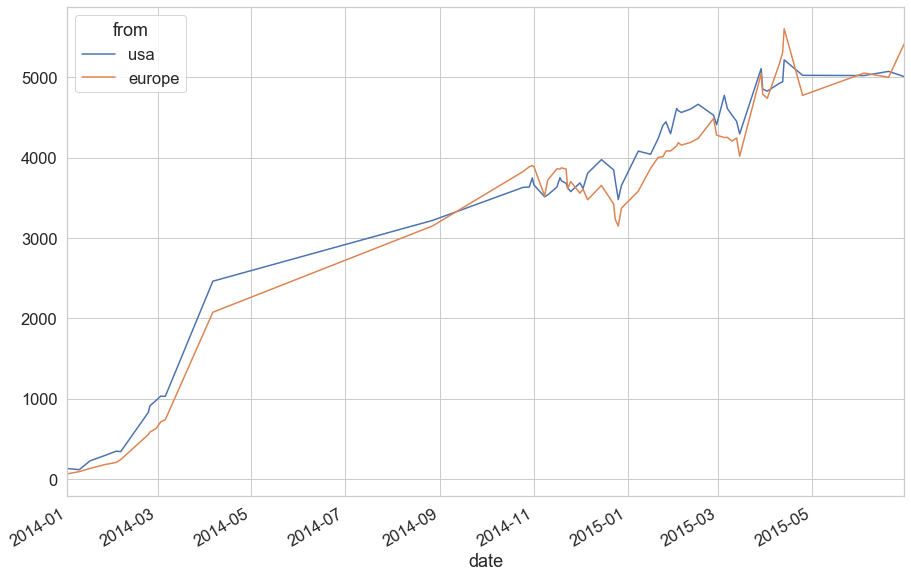

In [450]:
filtered_tos = filtered_tos.fillna(0)
test = filtered_tos[['usa', 'europe']]
test['europe'] += filtered_tos['uk']
test['europe'] += filtered_tos['germany']
test['europe'] += filtered_tos['france']
test['europe'] += filtered_tos['finland']
test['europe'] += filtered_tos['sweden']
test['europe'] += filtered_tos['hungary']
test['europe'] += filtered_tos['ireland']
test['europe'] += filtered_tos['spain']
test['europe'] += filtered_tos['switzerland']
#filtered_tos[['usa', 'uk', 'europe', 'germany', 'france', 'finland', 'sweden','hungary', 'ireland', 'spain', 'switzerland']].plot(figsize=(15,10))
test.plot(figsize=(15,10))

In [9]:
date = merged_inner['date'].apply(lambda x: x.strftime('%Y-%m-%d')).values
countries = ['worldwide','bulgaria', 'usa', 'france', 'germany', 'europe', 'finland', 'uk', 'sweden', 'hungary', 'ireland', 'latvia', 'lituania', 'luxembourg', 'netherland', 'romania', 'spain', 'switzerland']

test = df.select('date', 'name', 'cat', "from", pyspark.sql.functions.explode(col("to")).alias("to")).filter(col('to').isin(countries))
test = test.select('date', 'name', 'cat', "to", pyspark.sql.functions.explode(col("from")).alias("from")).filter(col('from').isin(countries))
test = test.filter(col('date').isin(date.tolist()))
test.count()
#test = test.toPandas()
#test = test.loc[merged_inner['date']]
#test.head()

243850

In [11]:
test = test.toPandas()
test.head()

date                                               name  \
0  2015-06-20                                10x K2 from Nirvana   
1  2015-06-20  4 Pack Tiresias Mist Natural Feminized Seeds S...   
2  2015-06-20  5 x Auto Seeds Fast Growing Ready In 3 Months ...   
3  2015-06-20     10x Belladonna Quality Seeds by Paradise Seeds   
4  2015-06-20  5 Autoflowering Cannabis Seeds Fast Growing Re...   

                    cat         to     from  
0  Drugs/Cannabis/Seeds     europe  germany  
1  Drugs/Cannabis/Seeds        usa      usa  
2  Drugs/Cannabis/Seeds  worldwide   europe  
3  Drugs/Cannabis/Seeds  worldwide  germany  
4  Drugs/Cannabis/Seeds  worldwide   europe

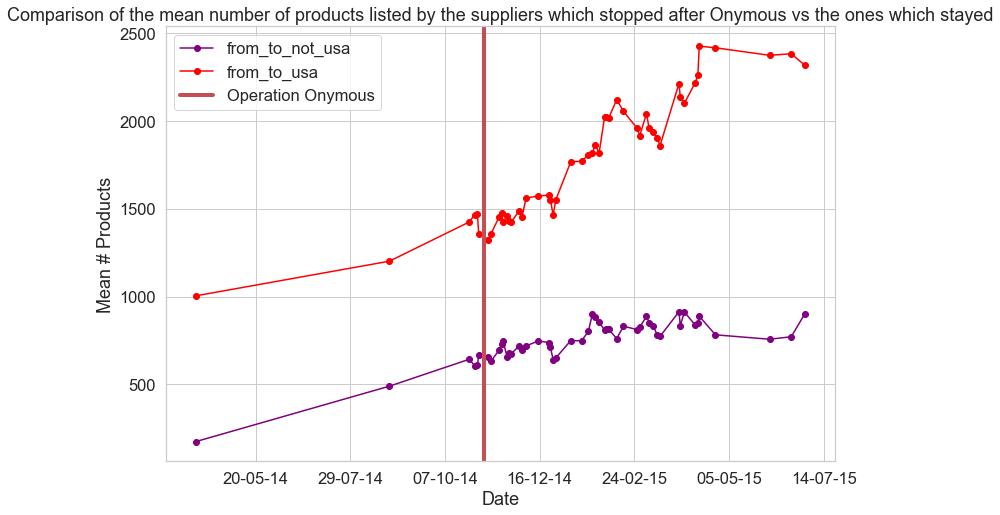

In [31]:
test['date'] = pd.to_datetime(test['date'],infer_datetime_format=True) 
test = test.sort_values(by='date', ascending=True, na_position='first')
from_usa = test[test['from'] == "usa"]
from_to_usa = from_usa[from_usa['to'] == "usa"].groupby('date').count()
from_to_not_usa = from_usa[from_usa['to'] != "usa"].groupby('date').count()


# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(from_to_not_usa.index,
        from_to_not_usa.name,
        '-o',
        color='purple',
        label='from_to_not_usa')
ax.plot(from_to_usa.index,
        from_to_usa.name,
        '-o',
        color='red',
       label='from_to_usa')



ax.set(xlabel="Date", ylabel="Mean # Products",
       title="Comparison of the mean number of products listed by the suppliers which stopped after Onymous vs the ones which stayed")

plt.axvline(linewidth=4, color='r', x="2014-11-05", label="Operation Onymous")

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.legend()
plt.show()
#plotNDate(from_to_not_usa.index,from_to_not_usa.name, 10,"Total number of active vendors per day", "# of vendors")

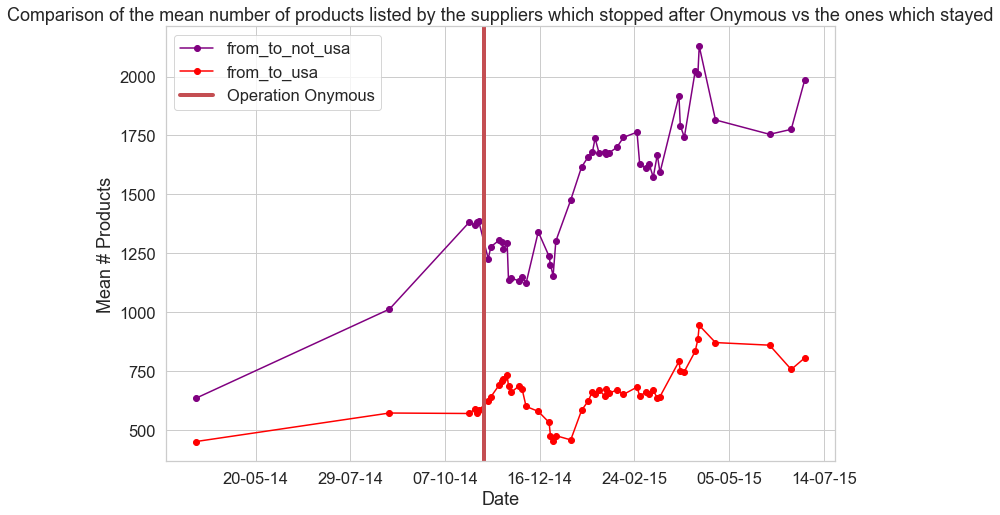

In [36]:
from_usa = test[test['from'].isin(['europe', 'uk', 'germany', 'france', 'finland', 'sweden', 'hungary', 'ireland', 'spain', 'switzerland'])]
from_to_usa = from_usa[from_usa['to'].isin(['europe', 'uk', 'germany', 'france', 'finland', 'sweden', 'hungary', 'ireland', 'spain', 'switzerland'])].groupby('date').count()
from_to_not_usa = from_usa[~from_usa['to'].isin(['europe', 'uk', 'germany', 'france', 'finland', 'sweden', 'hungary', 'ireland', 'spain', 'switzerland'])].groupby('date').count()


# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(from_to_not_usa.index,
        from_to_not_usa.name,
        '-o',
        color='purple',
        label='from_to_not_usa')
ax.plot(from_to_usa.index,
        from_to_usa.name,
        '-o',
        color='red',
       label='from_to_usa')



ax.set(xlabel="Date", ylabel="Mean # Products",
       title="Comparison of the mean number of products listed by the suppliers which stopped after Onymous vs the ones which stayed")

plt.axvline(linewidth=4, color='r', x="2014-11-05", label="Operation Onymous")

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.legend()
plt.show()
#plotNDate(from_to_not_usa.index,from_to_not_usa.name, 10,"Total number of active vendors per day", "# of vendors")

In [44]:
from_usa = test[test['from'].isin(['europe', 'uk', 'germany', 'france', 'finland', 'sweden', 'hungary', 'ireland', 'spain', 'switzerland'])]
from_usa[from_usa['to'] == 'worldwide'].count()


date    75358
name    75358
cat     75358
to      75358
from    75358
dtype: int64

In [72]:
date = merged_inner['date'].apply(lambda x: x.strftime('%Y-%m-%d')).values
countries = ['europe','bulgaria', 'france', 'germany', 'europe', 'finland', 'uk', 'sweden', 'hungary', 'ireland', 'latvia', 'lituania', 'luxembourg', 'netherland', 'romania', 'spain', 'switzerland']
countries_to = ['worldwide','europe','usa', 'bulgaria', 'france', 'germany', 'europe', 'finland', 'uk', 'sweden', 'hungary', 'ireland', 'latvia', 'lituania', 'luxembourg', 'netherland', 'romania', 'spain', 'switzerland']
test = df.select('date', 'name', 'cat', "from", pyspark.sql.functions.explode(col("to")).alias("to")).filter(~col('to').isin("None"))
test = test.select('date', 'name', 'cat', "to", pyspark.sql.functions.explode(col("from")).alias("from")).filter(~col('from').isin("None"))
test = test.filter(col('date').isin(date.tolist()))
test = test.filter(col('from').isin(countries))
test.count()

115745

In [298]:
# usa -> usa : 88928
# usa ->x usa : 38593
# europe ->x europe: 121144
# europe -> europe: 33000

import pyspark
after_top = after.select(pyspark.sql.functions.explode(col("to")).alias("to")).groupby("to").agg(count("to")).toPandas()
after_top = after_top.sort_values(by='count(to)', ascending=False, na_position='first')
after_top = after_top.set_index("to")
#plot = after_top.nlargest(20, "count(to)").plot.pie(y='count(to)', figsize=(15, 15))


In [299]:
before_top = before.select(pyspark.sql.functions.explode(col("to")).alias("to")).groupby("to").agg(count("to")).toPandas()
before_top = before_top.sort_values(by='count(to)', ascending=False, na_position='first')
before_top = before_top.set_index("to")
#plot = before_top.nlargest(20, "count(to)").plot.pie(y='count(to)', figsize=(15, 15))

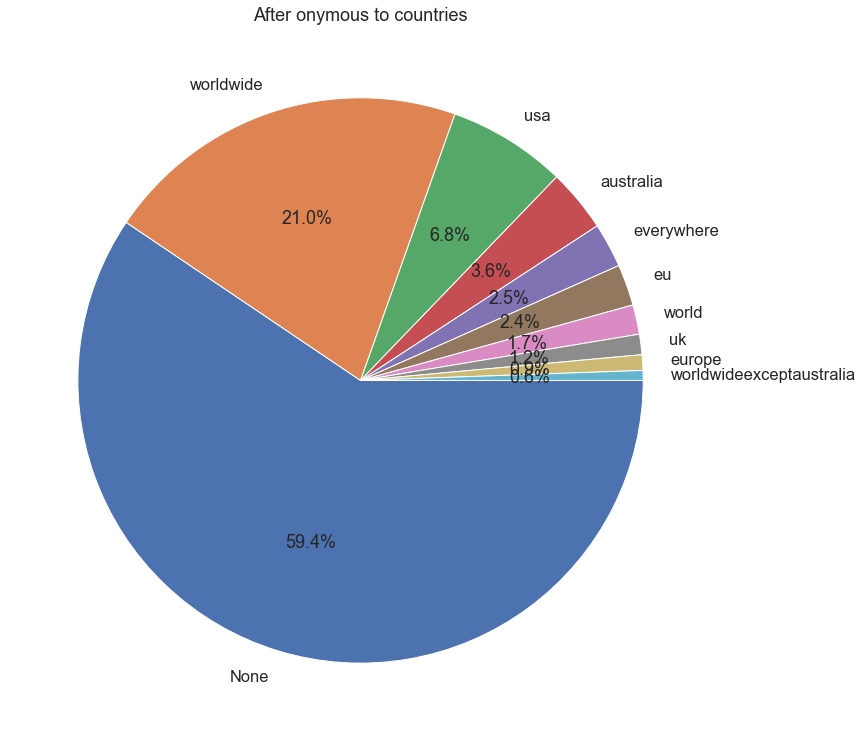

In [300]:
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(16,13))
top20 = after_top.nlargest(10, "count(to)")
values = top20['count(to)'].values
labels = top20.index
explode = np.zeros(len(values))
plt.pie(values, labels=labels,
explode=explode, autopct='%1.1f%%',
counterclock=False, shadow=False)
plt.title('After onymous to countries')
plt.show()

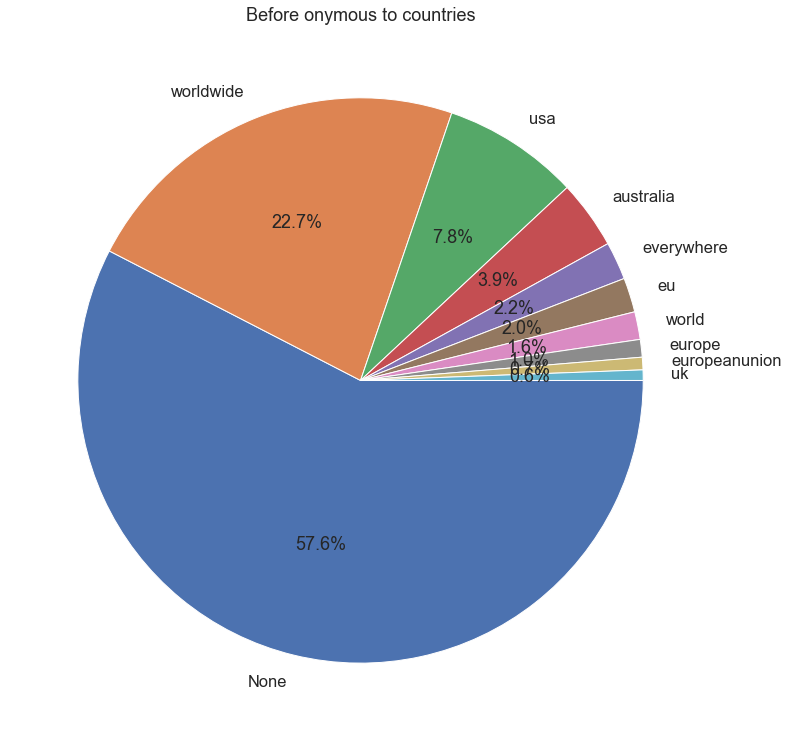

In [301]:
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(16,13))
top20 = before_top.nlargest(10, "count(to)")
values = top20['count(to)'].values
labels = top20.index
explode = np.zeros(len(values))
plt.pie(values, labels=labels,
explode=explode, autopct='%1.1f%%',
counterclock=False, shadow=False)
plt.title('Before onymous to countries')
plt.show()

In [285]:
before = before.groupby("from").agg(count("from").alias("before_count"))
after = after.groupby("from").agg(count("from").alias("after_count"))
before.join(after, after['from'] == before['from'], "inner").show()

+--------------------+------------+--------------------+-----------+
|                from|before_count|                from|after_count|
+--------------------+------------+--------------------+-----------+
|         [australia]|        1138|         [australia]|       1126|
|           [ukraine]|         108|           [ukraine]|        108|
|            [poland]|          55|            [poland]|         45|
|[uk, usa, philipp...|          62|[uk, usa, philipp...|         62|
|     [americansamoa]|           1|     [americansamoa]|          1|
|           [austria]|          27|           [austria]|         27|
|        [everywhere]|           1|        [everywhere]|          1|
|              [None]|        2190|              [None]|       2328|
|               [you]|           2|               [you]|          2|
|       [switzerland]|          24|       [switzerland]|         14|
|          [hongkong]|         203|          [hongkong]|        182|
|             [india]|         200

In [77]:
join = before.join(after, after.col == before.col, "inner")
join.withColumn("Sub", col("before_count")-col("after_count")).show(300)

+--------------------+------------+--------------------+-----------+----+
|                 col|before_count|                 col|after_count| Sub|
+--------------------+------------+--------------------+-----------+----+
|           australia|         683|           australia|        621|  62|
|            globally|           1|            globally|          1|   0|
|           instagram|           2|           instagram|          2|   0|
|                  us|          23|                  us|         21|   2|
|   mostpartsofeurope|           4|   mostpartsofeurope|          3|   1|
|        unitedstates|          16|        unitedstates|         19|  -3|
|  worldwidepriorfree|           1|  worldwidepriorfree|          1|   0|
|     internationally|          12|     internationally|         18|  -6|
|          everywhere|         378|          everywhere|        442| -64|
|              usonly|           3|              usonly|          3|   0|
|europeexpectscand...|           6|eur

In [17]:
test.show(300, False)

+--------------------------------------------------------------------------------+-----------+
|from                                                                            |count(from)|
+--------------------------------------------------------------------------------+-----------+
|[aruba]                                                                         |1          |
|[finland]                                                                       |265        |
|[uk, asia]                                                                      |210        |
|[kman]                                                                          |2          |
|[responsibleninjas]                                                             |23         |
|[you-freeshipping]                                                              |10         |
|[australia]                                                                     |177946     |
|[greece]                                         

# 4) Plan

##  4.1) Research questions

Due to the large amount of time needed to process the data and handle missing data, we will restrict a bit our research questions : 

* How did it affect the global sales on a short and a longer timescale ?
* How was the user traffic affected ?
* How was the "online traffic" popularity affected ?
* Were there any trends in the forums during this kind of intervention ?
* How did the prices evolve globally ?




## 4.2) Potential issues

The main issues of this project are caused by the missing data, it is very complicated to give meaningful information when we cannot be certain that we cover all the services.

## 4.3) Plannification

  - #### Dec 2th
  Data enrichment 
  Depth analysis of the data.
  Answer research questions.
  - #### Dec 9th
  Create meaningful vizualisation for the results.
  Put all together in a beautiful data story.
  - #### Dec 17th
  Finish producing content for the data story.

  ***
  - #### Dec 20th DEADLINE
  Finalize the data story for submission.
  ***